# First iteration

## Part 1: Get data and build model

In [59]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import sklearn.tree as tree
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
pd.set_option('display.max_columns', None)

## Data Sets Used

Freddie Mac has created a smaller dataset, which is a random sample of 50,000 loans selected from each full vintage year. Each vintage year has one origination data file and one monthly performance file, containing the same loan-level data fields as those included in the full dataset. We have located the `sample_2016.zip` file from the full dataset package, and used this zip package as our data source for this iteration.

The 2016 zip packages has two files: `sample_orig_2016.txt` and `sample_svcg_2016.txt`. The .txt files do not come with headers but instead, we refer to the User Guide (http://www.freddiemac.com/research/pdf/user_guide.pdf) to grab the name of the columns. We then join the two data files together by the loan number. 

It is expected that as we progressed further, we will be using larger and larger datasets. But for this first iteration, this is what we have chosen.

In [2]:
def get_data():
    dir = 'D:\\Backups\\StemData\\'
    file = 'sample_orig_2016.txt'
    file1 = 'sample_svcg_2016.txt'

    raw = pd.read_csv(dir+file, sep='|', header=None)
    raw.columns = ['credit_score', 'first_pmt_date', 'first_time', 'mat_date', 'msa', 'mi_perc', 'units',
                    'occ_status', 'ocltv', 'odti', 'oupb', 'oltv', 'oint_rate', 'channel', 'ppm', 'fixed_rate',
                    'state', 'prop_type','zip','loan_num', 'loan_purpose','oterm','num_borrowers', 'seller_name',
                    'servicer_name','exceed_conform']

    raw1 = pd.read_csv(dir+file1, sep='|', header=None)
    raw1.columns = ['loan_num', 'yearmon', 'curr_upb','curr_delinq','loan_age','remain_months', 'repurchased',
                     'modified', 'zero_bal','zero_date','curr_rate','curr_def_upb', 'ddlpi','mi_rec','net_proceeds',
                     'non_mi_rec', 'exp', 'legal_costs','maint_exp','tax_insur', 'misc_exp', 'loss','mod_exp']

    data = pd.merge(raw, raw1, on='loan_num', how='inner')

    data.drop(['seller_name', 'servicer_name', 'first_pmt_date', 'mat_date', 'msa'], axis=1, inplace=True)
    # all data must have the following: credit_score, ocltv, odti, oltv, oint_rate, curr_upb
    # remove any datapoints with missing values from the above features
    data.dropna(subset=['credit_score', 'odti', 'oltv', 'oint_rate', 'curr_upb'], how='any',inplace=True)
    data.credit_score = pd.to_numeric(data['credit_score'], errors='coerce')
    data.yearmon = pd.to_datetime(data['yearmon'], format='%Y%m')
    data.fillna(value=0, inplace=True, axis=1)
    
    return data

## Treatment of Missing Values (So Far)

Key features that are missing are more likely to be the result of reporting errors by the originator or the servicer, or incomplete information provided by the borrower. Similar to the Deep Learning paper we are reading, we have insisted that an observation must have no missing values in any of the following:

* FICO score

* LTV ratio

* Original interest rate

* original balance

Samples missing one of these variables are removed. 

After this step, we still have lots of missing values -- a lot of them came from the performance file (such as loan modification costs, legal expenses, etc). Our treatment so far is to treat the missing values as zero, as an missing value of these fields tend to be due to the fact that there hasn't been such an incidence yet.

It is clear that we will need to fine-tune our current treatment of missing values. This will be done in the second iteration by leveraging research already done by other STEM interns.



In [3]:
raw = get_data()
raw.isnull().values.any()

False

In [4]:
raw.sort_values(['loan_num'], ascending=True).groupby(['yearmon'], as_index=False)  ##consider move this into the next func
raw.set_index(['loan_num', 'yearmon'], inplace=True) ## consider move this into the next func

In [5]:
raw.isnull().values.any()

False

## Feature Space

Here, we also model after the Deep Learning for Mortgage Risk paper. In the paper, the authors have enumerated the possible states (current, 30 days delinquent, etc), and together, with other loan_level features (listed in Table 2 and Table 6 in the paper), formed the feature space for their model.

We do similar things here. The following code chunk further process the data: 

* Get the delinquency status that is associated with the loans and last observed month, and add a data column called `prev_delin`, in contrast with `curr_delinq`

* Remove the `curr_delinq` from our features but the feature space still has `prev_delinq` variable

* Use `curr_delinq` as our taget

* For the categorical variables, we convert them into dummy/indicator variables


In [6]:
def process_data(data):
    #data.sort_values(['loan_num'], ascending=True).groupby(['yearmon'], as_index=False)  ##consider move this out
    #data.set_index(['loan_num', 'yearmon'], inplace=True) ## consider move this out
    y = data['curr_delinq']
    #data['prev_delinq'] = data.curr_delinq.shift(1) ## needs attention here
    data['prev_delinq'] = data.groupby(level=0)['curr_delinq'].shift(1)
    print(sum(data.prev_delinq.isnull()))
    data.fillna(value=0, inplace=True, axis=1)
    data.drop(['curr_delinq'], axis=1, inplace=True)
    print(y.shape)
    ## how many classes are y?
    ## remove y from X
    X = pd.get_dummies(data, columns=['first_time', 'occ_status', 'channel', 'ppm', 'fixed_rate',
                                  'state', 'prop_type', 'loan_purpose', 'exceed_conform', 'repurchased'])
    #y = label_binarize(y, classes=[0, 1, 2, 3]) ## do we really have to do this?
    X[['credit_score','mi_perc','units','ocltv', 'odti', 'oupb', 'oltv', 'oint_rate','zip',
       'curr_upb','loan_age','remain_months', 'curr_rate','curr_def_upb', 'ddlpi','mi_rec','net_proceeds',
       'non_mi_rec', 'exp', 'legal_costs','maint_exp','tax_insur', 'misc_exp', 'loss','mod_exp']] = \
    scale(X[['credit_score','mi_perc','units','ocltv', 'odti', 'oupb', 'oltv', 'oint_rate','zip',
       'curr_upb','loan_age','remain_months', 'curr_rate','curr_def_upb', 'ddlpi','mi_rec','net_proceeds',
       'non_mi_rec', 'exp', 'legal_costs','maint_exp','tax_insur', 'misc_exp', 'loss','mod_exp']], with_mean=False)
    return X.values,y

In [7]:
train, target = process_data(raw)

24981
(203642,)


In [8]:
print(train.shape)
print(train)
print(target.shape)

(203642, 111)
[[ 16.29859015   0.           4.01181039 ...,   1.           0.           0.        ]
 [ 16.29859015   0.           4.01181039 ...,   1.           0.           0.        ]
 [ 16.29859015   0.           4.01181039 ...,   1.           0.           0.        ]
 ..., 
 [ 16.03500109   0.           4.01181039 ...,   1.           0.           0.        ]
 [ 16.38645317   2.16318079   4.01181039 ...,   1.           0.           0.        ]
 [ 17.66046695   2.59581694   4.01181039 ...,   1.           0.           0.        ]]
(203642,)


In [58]:
len(raw.columns)

41

## Getting plotting utility ready

We define the function to plot confusion matrix beow.

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Decision Tree with Pruning

Decision Trees. For the decision tree, you should implement or steal a decision tree algorithm (and by "implement or steal" I mean "steal"). Be sure to use some form of pruning. You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

In [10]:
raw.prev_delinq.value_counts()

0.0    203280
1.0       332
2.0        26
3.0         4
Name: prev_delinq, dtype: int64

C:\Users\jehun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   21.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:  4.1min finished
C:\Users\jehun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


clf Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio=1, svm_estimator=None)), ('dt', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
best_score -0.165998720285
               precision    recall  f1-score   support

curr_delinq 0       1.00      0.80      0.89     50790
curr_delinq 1       0.01      0.59      0.01       111
curr_delinq 2       0.12      0.89      0.21         9
curr_delinq 3       0.00      0.00      0.00         0

  avg / total       1.00      0.80      0.89     50911

Confusion matrix, without normalization
[[40852  9883    55     0     0]
 [   42    65     4     0     0]
 [    1     0     8     0     0]
 [    0     0     0     0     0]
 [    0     0     0     1     0]

C:\Users\jehun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 4
  .format(len(labels), len(target_names))
C:\Users\jehun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jehun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


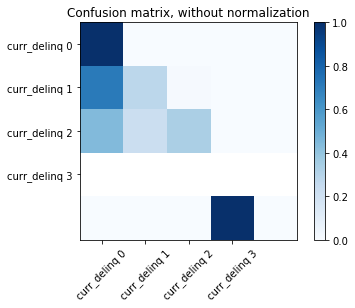

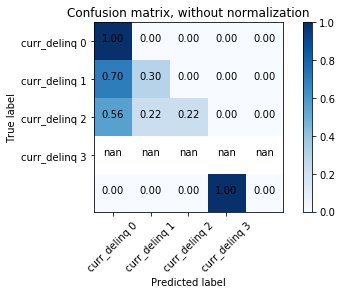

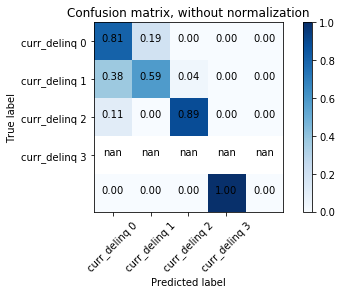

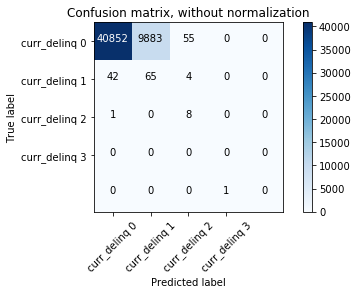

In [64]:
def fit_dt(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=778)
    smote = SMOTE(ratio=1)
    X_train_res, y_train_res = smote.fit_sample(X_train, y_train)
    clf = tree.DecisionTreeClassifier(criterion='gini', class_weight='balanced')
    pipe = Pipeline([('smote', smote), ('dt', clf)])
    param_grid = {'dt__max_depth': [2, 3, 4, 5, 6, 7, 8]}
    #sss = StratifiedShuffleSplit(n_splits=500, test_size=0.2)  ## no need for this given 50000 random sample
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=6, cv=10, scoring='neg_log_loss',verbose=5)
    grid_search.fit(X_train_res, y_train_res)
    clf = grid_search.best_estimator_
    print('clf', clf)
    print('best_score', grid_search.best_score_)
    y_pred = clf.predict(X_test)
    target_names = ['curr_delinq 0', 'curr_delinq 1', 'curr_delinq 2', 'curr_delinq 3']
    print(classification_report(y_test, y_pred, target_names=target_names))
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(conf_mat, classes=target_names,
                      title='Confusion matrix, without normalization')
    plt.show()    
    return clf, clf.predict(X_train_res), y_pred



dt, predict_dt, result_dt = fit_dt(train, target)    

In [45]:
import scipy
scipy.stats.itemfreq(predict_dt)
scipy.stats.itemfreq(result_dt)


#import graphviz 
#dot_data = tree.export_graphviz(dt, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph

array([[    0, 50753],
       [    1,   142],
       [    2,    15],
       [    3,     1]], dtype=int64)

## Nueral Network Model: First Iteration


We had used the grid search approach to find the the best number of hidden layers (out of 1, 3, 5, and 7). For each of these options, we started out with the full set of features, then reduce it to 70% of that for each subsequent hidden layers.

The authors' deep learning give them a probability transition matrix. 

Our model below gives us a probability matrix for each observation data. This is slightly different.

However, with a bit more work, we can convert our probability matrix produced from our model into the probability transition matrix, so that it not only predicts for us, when a new data comes in, what is the most likely delinquent status of a new loan, but also tell us what is the probability that a loan of a particular delinquency status will transition into a different status type. 

In [ ]:
def gridSearch_nn(X, y):
    #X_train, y_train, X_test, y_test = train_test_split(X,y)
    mlp = MLPClassifier(solver='adam', alpha=1e-5, shuffle=True, learning_rate='invscaling',
         verbose=True)
    parameters = {'hidden_layer_sizes':[(519), (519, 363, 363), (519, 363, 363, 363, 363), (519, 363, 363, 363, 363, 363, 363)]}
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)  ## no need for this given 50000 random sample
    gs = GridSearchCV(estimator=mlp, param_grid=parameters, n_jobs=6, cv=sss, scoring='roc_auc',verbose=5)
    gs.fit(X, y)
    clf = gs.best_estimator_
    print(clf)
    print(gs.best_score_)
    mat = clf.predict_proba(X)
    print(mat)
    
    return clf, gs.best_score_, mat


if  __name__== '__main__':
    clf, score, mat = gridSearch_nn(train, target)

In [ ]:
print(mat)

## Notes 

1. We had 519 variables and the authors had 294. But to be sure, we don't have a greater number of features compared to the authors. I think this is just an artifact of our different implementations as the authors do have more data than us.

2. ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output as we had done. 